In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

print('Done')

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1660 Ti
Done


In [3]:
model = torch.load('/home/gerard/ownCloud/varis_tesi/GlossBERT_datasets/SemCor_full.pt')
model.cuda()
print('Done')

Done


In [2]:
from transformers import BertTokenizer

if 'tokenizer' not in globals():
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Done')

Loading BERT tokenizer...
Done


In [4]:
import pandas as pd
import time
import itertools
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler

# Load the dataset into a pandas dataframe.
dataset_test = pd.read_csv('GlossBERT_datasets/Evaluation_Datasets/ALL/ALL_test_sent_cls.csv', delimiter='\t', header=0)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(dataset_test.shape[0]))

# Create sentence and label lists
sentences_test = dataset_test.sentence.values
glosses_test = dataset_test.gloss.values.tolist()
labels_test = dataset_test.label.values

print('Preparting BERT test input...')

#if 'encoded_dict' not in globals():
input_ids_test = []
attention_masks_test = []

start_time = time.time()
counter = 0

for (sent, gloss) in itertools.islice(zip(sentences_test, glosses_test), len(sentences_test)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                      sent,       # sentences are tokenized, so split by whitespace
                      gloss,               # glosses require tokenization
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      padding = 'max_length', truncation = True, max_length = 100, # Pad & truncate all sentences.
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt'     # Return pytorch tensors.
                 )
        
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])
    
    counter += 1
    if counter % 10000 == 0:
        print(f'...{counter} in {time.time() - start_time}')

print("Elapsed time: ", time.time() - start_time)

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
print('Done')

Number of test sentences: 58,021

Preparting BERT test input...
...10000 in 5.197318077087402
...20000 in 10.00934386253357
...30000 in 15.268535137176514
...40000 in 20.358628034591675
...50000 in 26.19759964942932
Elapsed time:  30.13491439819336
Done


In [5]:
print(sentences_test[0:1])
print(glosses_test[0:1])
print(labels_test[0:1])
print(input_ids_test[0])
print(attention_masks_test[0])

['The art of change-ringing is peculiar to the English , and , like most English peculiarities , unintelligible to the rest of the world .']
['the creation of beautiful or significant things']
tensor([0])
tensor([  101,  1996,  2396,  1997,  2689,  1011, 13060,  2003, 14099,  2000,
         1996,  2394,  1010,  1998,  1010,  2066,  2087,  2394, 14099,  6447,
         1010,  4895, 18447, 13348, 18507,  2000,  1996,  2717,  1997,  1996,
         2088,  1012,   102,  1996,  4325,  1997,  3376,  2030,  3278,  2477,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 

In [8]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

start_time = time.time()
counter = 0

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask, labels=None)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  
    counter += 1
    if counter % 10000 == 0:
        print(f'...{counter} in {time.time() - start_time}')

print('    DONE.')

Predicting labels for 58,021 test sentences...
    DONE.


In [9]:
print('Positive samples: %d of %d (%.2f%%)' % (dataset_test.label.sum(), len(dataset_test.label), (dataset_test.label.sum() / len(dataset_test.label) * 100.0)))

Positive samples: 7611 of 58021 (13.12%)


In [34]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

print('    DONE.')

Calculating Matthews Corr. Coef. for each batch...


/home/gerard/.conda/envs/sbert/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


    DONE.


In [32]:
print(glosses_test[5:9])
print(true_labels[0][5:9])
print(predictions[0][5:9])
print(np.argmax(predictions[0], axis=1)[5:9])

['characteristic of one only; distinctive or special', 'unique or specific to a person or thing or category', 'beyond or deviating from the usual or expected', 'markedly different from the usual']
[1 1 0 0]
[[ 1.951223   -1.6415026 ]
 [ 1.2465233  -0.6646069 ]
 [ 1.0632874  -0.44000393]
 [ 2.1456618  -1.8866969 ]]
[0 0 0 0]


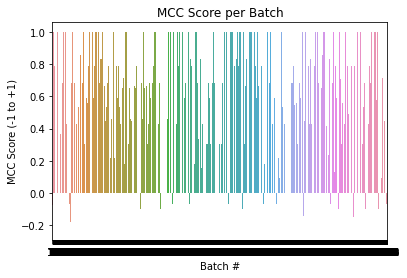

    DONE.


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()
print('    DONE.')

In [35]:
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, recall_score

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

f1 = f1_score(flat_true_labels, flat_predictions)
precision = precision_score(flat_true_labels, flat_predictions)
recall = recall_score(flat_true_labels, flat_predictions)
    
print('Total MCC: %.3f' % mcc)
print('Total F1: %.3f' % f1)
print('Total P: %.3f' % precision)
print('Total R: %.3f' % recall)


Total MCC: 0.606
Total F1: 0.650
Total P: 0.713
Total R: 0.598


In [27]:
print(flat_predictions[0:10])
print(flat_true_labels[0:10])

[0 1 0 0 1 0 0 0 0 0]
[0 0 1 0 1 1 1 0 0 0]
